In [1]:
import re

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

[Датасет](https://www.kaggle.com/rajeevw/ufcdata) представляет собой полный список всех боёв **UFC**. Каждая строка содержит информацию об обоих бойцах, деталях боя и о том, кто победил. 

Весь датасет состоит из 4-х файлов:
* `data.csv` - список всех боёв UFC и информация о бое
* `raw_fighter_details.csv` - список всех бойцов UFC за эти годы и информация о них
* `preprocessed_data.csv` - обработанные данные, содержащие всю необходимую информацию для составления прогнозов
* `raw_total_fight_data.csv` - необработанные данные для того, чтобы можно было составить и обработать данные самим

Импортируем таблицу с сырыми данными (тут только бои). При этом, замечено, что некоторые столбцы имеют нулевые значения в столбце `Winner` - их будет проще удалить и оставить только те индексы в таблице, которые не связаны с этими нулевыми значениями.

In [2]:
raw_data = pd.read_csv('./raw_total_fight_data.csv', delimiter=';')
indexes_not_null = raw_data['Winner'].dropna().index
raw_data = raw_data.loc[indexes_not_null, :]
raw_data

,R_fighter,B_fighter,R_KD,B_KD,R_SIG_STR.,B_SIG_STR.,R_SIG_STR_pct,B_SIG_STR_pct,R_TOTAL_STR.,B_TOTAL_STR.,...,B_GROUND,win_by,last_round,last_round_time,Format,Referee,date,location,Fight_type,Winner
0,Adrian Yanez,Gustavo Lopez,2,0,41 of 103,23 of 51,39%,45%,41 of 103,23 of 51,...,0 of 0,KO/TKO,3,0:27,3 Rnd (5-5-5),Chris Tognoni,"March 20, 2021","Las Vegas, Nevada, USA",Bantamweight Bout,Adrian Yanez
1,Trevin Giles,Roman Dolidze,0,0,27 of 57,32 of 67,47%,47%,43 of 73,75 of 110,...,1 of 2,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Herb Dean,"March 20, 2021","Las Vegas, Nevada, USA",Middleweight Bout,Trevin Giles
2,Tai Tuivasa,Harry Hunsucker,1,0,14 of 18,2 of 6,77%,33%,14 of 18,2 of 6,...,0 of 0,KO/TKO,1,0:49,3 Rnd (5-5-5),Herb Dean,"March 20, 2021","Las Vegas, Nevada, USA",Heavyweight Bout,Tai Tuivasa
3,Cheyanne Buys,Montserrat Conejo,0,0,31 of 65,15 of 41,47%,36%,49 of 87,136 of 168,...,0 of 0,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Mark Smith,"March 20, 2021","Las Vegas, Nevada, USA",Women's Strawweight Bout,Montserrat Conejo
4,Marion Reneau,Macy Chiasson,0,0,30 of 63,51 of 138,47%,36%,59 of 93,92 of 184,...,2 of 4,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Mark Smith,"March 20, 2021","Las Vegas, Nevada, USA",Women's Bantamweight Bout,Macy Chiasson
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6007,Remco Pardoel,Alberta Cerra Leon,0,0,4 of 6,1 of 3,66%,33%,20 of 22,9 of 11,...,0 of 2,Submission,1,9:51,No Time Limit,John McCarthy,"March 11, 1994","Denver, Colorado, USA",Open Weight Bout,Remco Pardoel
6008,Orlando Wiet,Robert Lucarelli,0,0,8 of 12,2 of 6,66%,33%,11 of 15,2 of 6,...,0 of 0,KO/TKO,1,2:50,No Time Limit,John McCarthy,"March 11, 1994","Denver, Colorado, USA",Open Weight Bout,Orlando Wiet
6009,Johnny Rhodes,David Levicki,0,0,11 of 17,4 of 5,64%,80%,74 of 86,95 of 102,...,1 of 1,KO/TKO,1,12:13,No Time Limit,John McCarthy,"March 11, 1994","Denver, Colorado, USA",Open Weight Bout,Johnny Rhodes
6010,Patrick Smith,Ray Wizard,0,0,1 of 1,1 of 1,100%,100%,1 of 1,2 of 2,...,0 of 0,Submission,1,0:58,No Time Limit,John McCarthy,"March 11, 1994","Denver, Colorado, USA",Open Weight Bout,Patrick Smith


Как можно заметить, таблица имеет нулевые значения в столбце `Referee`, но нам этот столбец не понадобится, поэтому просто оставим как есть.

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5902 entries, 0 to 6011
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   R_fighter        5902 non-null   object
 1   B_fighter        5902 non-null   object
 2   R_KD             5902 non-null   int64 
 3   B_KD             5902 non-null   int64 
 4   R_SIG_STR.       5902 non-null   object
 5   B_SIG_STR.       5902 non-null   object
 6   R_SIG_STR_pct    5902 non-null   object
 7   B_SIG_STR_pct    5902 non-null   object
 8   R_TOTAL_STR.     5902 non-null   object
 9   B_TOTAL_STR.     5902 non-null   object
 10  R_TD             5902 non-null   object
 11  B_TD             5902 non-null   object
 12  R_TD_pct         5902 non-null   object
 13  B_TD_pct         5902 non-null   object
 14  R_SUB_ATT        5902 non-null   int64 
 15  B_SUB_ATT        5902 non-null   int64 
 16  R_REV            5902 non-null   int64 
 17  B_REV            5902 non-null   

Загрузим таблицу бойцов, которая нам впоследствии понадобится.

In [4]:
raw_fighters = pd.read_csv('./raw_fighter_details.csv')
raw_fighters

,fighter_name,Height,Weight,Reach,Stance,DOB,SLpM,Str_Acc,SApM,Str_Def,TD_Avg,TD_Acc,TD_Def,Sub_Avg
0,Tom Aaron,NaN,155 lbs.,NaN,NaN,"Jul 13, 1978",0.00,0%,0.00,0%,0.00,0%,0%,0.0
1,Papy Abedi,"5' 11""",185 lbs.,NaN,Southpaw,"Jun 30, 1978",2.80,55%,3.15,48%,3.47,57%,50%,1.3
2,Shamil Abdurakhimov,"6' 3""",235 lbs.,"76""",Orthodox,"Sep 02, 1981",2.45,44%,2.45,58%,1.23,24%,47%,0.2
3,Danny Abbadi,"5' 11""",155 lbs.,NaN,Orthodox,"Jul 03, 1983",3.29,38%,4.41,57%,0.00,0%,77%,0.0
4,Hiroyuki Abe,"5' 6""",145 lbs.,NaN,Orthodox,NaN,1.71,36%,3.11,63%,0.00,0%,33%,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3591,Zhang Tiequan,"5' 8""",155 lbs.,"69""",Orthodox,"Jul 25, 1978",1.23,36%,2.14,51%,1.95,58%,75%,3.4
3592,Alex Zuniga,NaN,145 lbs.,NaN,NaN,NaN,0.00,0%,0.00,0%,0.00,0%,0%,0.0
3593,George Zuniga,"5' 9""",185 lbs.,NaN,NaN,NaN,7.64,38%,5.45,37%,0.00,0%,100%,0.0
3594,Allan Zuniga,"5' 7""",155 lbs.,"70""",Orthodox,"Apr 04, 1992",3.93,52%,1.80,61%,0.00,0%,57%,1.0


Здесь всё не так гладко и много пустых полей.

In [5]:
raw_fighters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3596 entries, 0 to 3595
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   fighter_name  3596 non-null   object 
 1   Height        3333 non-null   object 
 2   Weight        3522 non-null   object 
 3   Reach         1684 non-null   object 
 4   Stance        2792 non-null   object 
 5   DOB           2857 non-null   object 
 6   SLpM          3596 non-null   float64
 7   Str_Acc       3596 non-null   object 
 8   SApM          3596 non-null   float64
 9   Str_Def       3596 non-null   object 
 10  TD_Avg        3596 non-null   float64
 11  TD_Acc        3596 non-null   object 
 12  TD_Def        3596 non-null   object 
 13  Sub_Avg       3596 non-null   float64
dtypes: float64(4), object(10)
memory usage: 393.4+ KB


В этой работе мы будем составлять свою таблицу по следующим признакам: 
- возраст бойцов
- размах рук
- рост
- вес
- количество проведенных боёв
- количество побед и поражений  

После составления окончательной таблицы признаков, будем их масштабировать и обучать модель.

Добавим колонку, обозначающая год каждого боя, чтобы определить только актуальные данные, с которыми мы будем работать.

In [6]:
raw_data['year'] = raw_data['date'].apply(lambda x: int(x.split(',')[-1].strip()))

In [7]:
values = raw_data['year'].value_counts().sort_values(ascending=False)
indexes = values.index

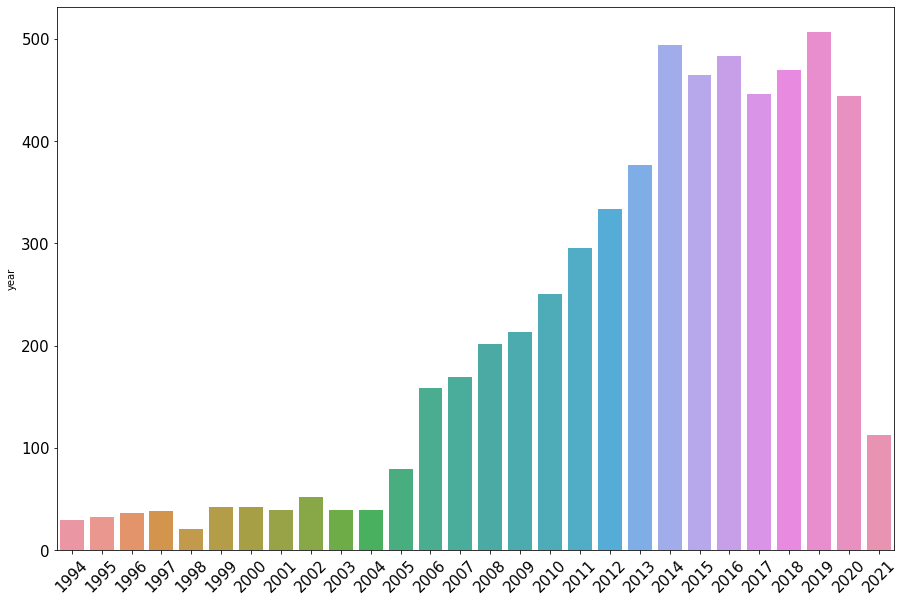

In [8]:
plt.figure(figsize=(15, 10))
sns.barplot(x=indexes, y=values)
ax = plt.gca()
ax.tick_params('x', labelrotation=45, labelsize=15)
ax.tick_params('y', labelsize=15)

Поскольку с 2005 года начинается активное распространнение UFC, то и будем рассматривать датасет, начиная с этого года.

In [9]:
raw_data = raw_data[raw_data['year'] > 2005]

In [10]:
raw_data

,R_fighter,B_fighter,R_KD,B_KD,R_SIG_STR.,B_SIG_STR.,R_SIG_STR_pct,B_SIG_STR_pct,R_TOTAL_STR.,B_TOTAL_STR.,...,win_by,last_round,last_round_time,Format,Referee,date,location,Fight_type,Winner,year
0,Adrian Yanez,Gustavo Lopez,2,0,41 of 103,23 of 51,39%,45%,41 of 103,23 of 51,...,KO/TKO,3,0:27,3 Rnd (5-5-5),Chris Tognoni,"March 20, 2021","Las Vegas, Nevada, USA",Bantamweight Bout,Adrian Yanez,2021
1,Trevin Giles,Roman Dolidze,0,0,27 of 57,32 of 67,47%,47%,43 of 73,75 of 110,...,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Herb Dean,"March 20, 2021","Las Vegas, Nevada, USA",Middleweight Bout,Trevin Giles,2021
2,Tai Tuivasa,Harry Hunsucker,1,0,14 of 18,2 of 6,77%,33%,14 of 18,2 of 6,...,KO/TKO,1,0:49,3 Rnd (5-5-5),Herb Dean,"March 20, 2021","Las Vegas, Nevada, USA",Heavyweight Bout,Tai Tuivasa,2021
3,Cheyanne Buys,Montserrat Conejo,0,0,31 of 65,15 of 41,47%,36%,49 of 87,136 of 168,...,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Mark Smith,"March 20, 2021","Las Vegas, Nevada, USA",Women's Strawweight Bout,Montserrat Conejo,2021
4,Marion Reneau,Macy Chiasson,0,0,30 of 63,51 of 138,47%,36%,59 of 93,92 of 184,...,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Mark Smith,"March 20, 2021","Las Vegas, Nevada, USA",Women's Bantamweight Bout,Macy Chiasson,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5508,Spencer Fisher,Aaron Riley,0,0,25 of 65,9 of 23,38%,39%,30 of 70,17 of 32,...,TKO - Doctor's Stoppage,1,5:00,3 Rnd (5-5-5),John McCarthy,"January 16, 2006","Las Vegas, Nevada, USA",Welterweight Bout,Spencer Fisher,2006
5509,Jason Von Flue,Alex Karalexis,0,0,28 of 68,18 of 60,41%,30%,50 of 90,35 of 77,...,Submission,3,1:17,3 Rnd (5-5-5),Steve Mazzagatti,"January 16, 2006","Las Vegas, Nevada, USA",Welterweight Bout,Jason Von Flue,2006
5510,Joshua Burkman,Drew Fickett,0,0,7 of 9,2 of 8,77%,25%,8 of 10,2 of 8,...,Submission,1,1:07,3 Rnd (5-5-5),Mario Yamasaki,"January 16, 2006","Las Vegas, Nevada, USA",Welterweight Bout,Joshua Burkman,2006
5511,Chris Leben,Jorge Rivera,1,0,10 of 17,5 of 10,58%,50%,16 of 23,6 of 11,...,KO/TKO,1,1:44,3 Rnd (5-5-5),John McCarthy,"January 16, 2006","Las Vegas, Nevada, USA",Middleweight Bout,Chris Leben,2006


Мы получили таблицу, состояющую из 5414 боёв, проведенных, начиная с 2006-го года. Тогда получим имена всех бойцов, которые принимали участие в боях в это время, чтобы затем из всей таблицы бойцов отобрать только тех, кто участвовал, начиная с 2006-го года.

In [11]:
raw_fighters['fighter_name'].tolist()

['Tom Aaron',
 'Papy Abedi',
 'Shamil Abdurakhimov',
 'Danny Abbadi',
 'Hiroyuki Abe',
 'Ricardo Abreu',
 'Daichi Abe',
 'David Abbott',
 'Klidson Abreu',
 'Daniel Acacio',
 'Scott Adams',
 'Juan Adams',
 'Anthony Adams',
 'Sam Adkins',
 'Israel Adesanya',
 'Zarrukh Adashev',
 'Marcelo Aguiar',
 'Nick Agallar',
 'Mariya Agapova',
 'Edwin Aguilar',
 'Fabio Aguiar',
 'Jessica Aguilar',
 'Kevin Aguilar',
 'Christian Aguilera',
 'Hitomi Akano',
 'Mike Aina',
 'Rostem Akman',
 'Omari Akhmedov',
 'Razak Al-Hassan',
 'Yoshihiro Akiyama',
 'Herdem Alacabek',
 'Mostapha Al-Turk',
 'Javi Alanis',
 'Heili Alateng',
 'Brett Albee',
 'Amir Albazi',
 'Wes Albritton',
 'John Albert',
 'Aleksandra Albu',
 'Junior Albini',
 'Israel Albuquerque',
 'Juan Alcain',
 'Ildemar Alcantara',
 'Alfonso Alcarez',
 'Iuri Alcantara',
 'Gilbert Aldana',
 'Hector Aldana',
 'Irene Aldana',
 'JJ Aldrich',
 'Jose Aldo',
 'Kenneth Alexander',
 'Jim Alers',
 'Houston Alexander',
 'John Alessio',
 'Marcio Alexandre Junior'

Всего нужных нам бойцов 1877. С ними и будем работать. Не забывает при создании таблицы переобозначить индексы с помощью `reset_index`.

In [12]:
fighters_ge_2005 = pd.concat([raw_data['R_fighter'], raw_data['B_fighter']])
fighters_ge_2005 = fighters_ge_2005.unique()
fighters_ge_2005.shape

(1877,)

In [13]:
raw_fighters = raw_fighters[raw_fighters['fighter_name'].isin(fighters_ge_2005)].reset_index(drop=True)
raw_fighters

,fighter_name,Height,Weight,Reach,Stance,DOB,SLpM,Str_Acc,SApM,Str_Def,TD_Avg,TD_Acc,TD_Def,Sub_Avg
0,Papy Abedi,"5' 11""",185 lbs.,NaN,Southpaw,"Jun 30, 1978",2.80,55%,3.15,48%,3.47,57%,50%,1.3
1,Shamil Abdurakhimov,"6' 3""",235 lbs.,"76""",Orthodox,"Sep 02, 1981",2.45,44%,2.45,58%,1.23,24%,47%,0.2
2,Danny Abbadi,"5' 11""",155 lbs.,NaN,Orthodox,"Jul 03, 1983",3.29,38%,4.41,57%,0.00,0%,77%,0.0
3,Ricardo Abreu,"5' 11""",185 lbs.,NaN,Orthodox,"Apr 27, 1984",3.79,31%,3.98,68%,2.13,42%,100%,0.7
4,Daichi Abe,"5' 11""",170 lbs.,"71""",Orthodox,"Nov 27, 1991",3.80,33%,4.49,56%,0.33,50%,0%,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1872,Fares Ziam,"6' 1""",155 lbs.,"75""",Orthodox,"Mar 21, 1997",1.90,47%,1.37,66%,0.50,11%,65%,0.0
1873,Cat Zingano,"5' 6""",145 lbs.,"68""",Southpaw,"Jul 01, 1982",2.57,61%,1.63,47%,2.77,65%,42%,0.8
1874,Joao Zeferino,"5' 11""",170 lbs.,NaN,Orthodox,"Jan 15, 1986",0.83,36%,2.60,48%,0.50,5%,50%,1.0
1875,Zhang Tiequan,"5' 8""",155 lbs.,"69""",Orthodox,"Jul 25, 1978",1.23,36%,2.14,51%,1.95,58%,75%,3.4


Если ещё раз проанализировать датасет бойцов, то можно заметить, что почти все данные известны, кроме размаха рук и даты рождения.

In [14]:
raw_fighters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1877 entries, 0 to 1876
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   fighter_name  1877 non-null   object 
 1   Height        1875 non-null   object 
 2   Weight        1877 non-null   object 
 3   Reach         1487 non-null   object 
 4   Stance        1834 non-null   object 
 5   DOB           1852 non-null   object 
 6   SLpM          1877 non-null   float64
 7   Str_Acc       1877 non-null   object 
 8   SApM          1877 non-null   float64
 9   Str_Def       1877 non-null   object 
 10  TD_Avg        1877 non-null   float64
 11  TD_Acc        1877 non-null   object 
 12  TD_Def        1877 non-null   object 
 13  Sub_Avg       1877 non-null   float64
dtypes: float64(4), object(10)
memory usage: 205.4+ KB


Напишем функцию, переводяющую значения таблицы из футов в сантиметры. Эта функция будет применяться к какому-либо столбцу.

In [15]:
def inches_to_cms(x):
    if x is np.NaN:
        return x
    elif len(x.split("'")) == 2:
        feet = float(x.split("'")[0])
        inches = int(x.split("'")[1].replace(' ', '').replace('"',''))
        return (feet * 30.48) + (inches * 2.54)
    else:
        return float(x.replace('"','')) * 2.54

Теперь переведём рост бойцов из футов в сантиметры.

In [16]:
raw_fighters['Height'] = raw_fighters['Height'].apply(inches_to_cms)
raw_fighters['Height']

0       180.34
1       190.50
2       180.34
3       180.34
4       180.34
         ...  
1872    185.42
1873    167.64
1874    180.34
1875    172.72
1876    170.18
Name: Height, Length: 1877, dtype: float64

То же самое проделаем с весом: переведем фунты в килограммы с помощью написанной функции.

In [17]:
def lbs_to_kg(x):
    if x is np.NaN:
        return x
    else:
        lbs = x.removesuffix(' lbs.')
        return float(lbs) * 0.45

In [18]:
raw_fighters['Weight'] = raw_fighters['Weight'].apply(lbs_to_kg)
raw_fighters['Weight']

0        83.25
1       105.75
2        69.75
3        83.25
4        76.50
         ...  
1872     69.75
1873     65.25
1874     76.50
1875     69.75
1876     69.75
Name: Weight, Length: 1877, dtype: float64

Для примера приведена функция, которая удалит из столбца значения с процентами и поделит их на 100.

In [19]:
def pct(x):
    if x is np.NaN:
        return x
    else:
        pct = x.removesuffix('%')
        return float(pct) / 100

In [20]:
raw_fighters['Str_Acc'] = raw_fighters['Str_Acc'].apply(pct)
raw_fighters

,fighter_name,Height,Weight,Reach,Stance,DOB,SLpM,Str_Acc,SApM,Str_Def,TD_Avg,TD_Acc,TD_Def,Sub_Avg
0,Papy Abedi,180.34,83.25,NaN,Southpaw,"Jun 30, 1978",2.80,0.55,3.15,48%,3.47,57%,50%,1.3
1,Shamil Abdurakhimov,190.50,105.75,"76""",Orthodox,"Sep 02, 1981",2.45,0.44,2.45,58%,1.23,24%,47%,0.2
2,Danny Abbadi,180.34,69.75,NaN,Orthodox,"Jul 03, 1983",3.29,0.38,4.41,57%,0.00,0%,77%,0.0
3,Ricardo Abreu,180.34,83.25,NaN,Orthodox,"Apr 27, 1984",3.79,0.31,3.98,68%,2.13,42%,100%,0.7
4,Daichi Abe,180.34,76.50,"71""",Orthodox,"Nov 27, 1991",3.80,0.33,4.49,56%,0.33,50%,0%,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1872,Fares Ziam,185.42,69.75,"75""",Orthodox,"Mar 21, 1997",1.90,0.47,1.37,66%,0.50,11%,65%,0.0
1873,Cat Zingano,167.64,65.25,"68""",Southpaw,"Jul 01, 1982",2.57,0.61,1.63,47%,2.77,65%,42%,0.8
1874,Joao Zeferino,180.34,76.50,NaN,Orthodox,"Jan 15, 1986",0.83,0.36,2.60,48%,0.50,5%,50%,1.0
1875,Zhang Tiequan,172.72,69.75,"69""",Orthodox,"Jul 25, 1978",1.23,0.36,2.14,51%,1.95,58%,75%,3.4


Переведем размах рук в сантиметры, так же, как делали с ростом

In [21]:
raw_fighters['Reach'] = raw_fighters['Reach'].apply(inches_to_cms)
raw_fighters['Reach']

0          NaN
1       193.04
2          NaN
3          NaN
4       180.34
         ...  
1872    190.50
1873    172.72
1874       NaN
1875    175.26
1876    177.80
Name: Reach, Length: 1877, dtype: float64

В библиотеке Pandas есть функция `to_datetime`, переводящая строки вида "Sep 02, 1981" к типу `Timestamp` библиотеки Pandas. Далее приведен пример, в котором из стобца `DOB` происходит перевод такого значения к нужному типу. Это понадобится нам впоследствии, когда мы будем высчитывать возраст бойцов и их опыт.

In [22]:
pd.to_datetime(raw_fighters.loc[1, 'DOB'])

Timestamp('1981-09-02 00:00:00')

До этого мы использовали специальные функции, которые переводят футы в сантиметры, фунты в килограммы и т.п. Все эти функции применялись к столбцам таблицы с помощью метода `apply` объекта `DataFrame`. Особенность заключалось в том, что там функция применялась к целом столбцу как объекту `Series`. 

Далее приведена как примера функция, которая принимает на вход целую **строку** как объект `Series`. Передача целой строки означает то, что мы можем обратиться к каждому элементу в строке ровно так же, как делали это с целой таблицей `DataFrame`. Т.е., обратившись по названию столбца, мы можем получить значение ячейки и изменить её. 

Для того, чтобы применить функцию к целым строкам нужно задать параметр `axis=1` в функции `apply`. Стоит отметить, что в операторе `return` пишется `X`, означающее, что результатом работы функции будет являться та же самая строка, что и пришла, просто с несколько измененными колонками. Поэтому, на выходе мы получим полноценную таблицу `DataFrame`. 

In [23]:
def f(X):
    if X['Str_Def'][-1] == '%':
        X['Str_Def'] = float(X['Str_Def'].removesuffix('%')) / 100
    if X['TD_Acc'][-1] == '%':
        X['TD_Acc'] = float(X['TD_Acc'].removesuffix('%')) / 100
    if X['TD_Def'][-1] == '%':
        X['TD_Def'] = float(X['TD_Def'].removesuffix('%')) / 100
    return X

In [24]:
raw_fighters.apply(f, axis=1)

,fighter_name,Height,Weight,Reach,Stance,DOB,SLpM,Str_Acc,SApM,Str_Def,TD_Avg,TD_Acc,TD_Def,Sub_Avg
0,Papy Abedi,180.34,83.25,NaN,Southpaw,"Jun 30, 1978",2.80,0.55,3.15,0.48,3.47,0.57,0.50,1.3
1,Shamil Abdurakhimov,190.50,105.75,193.04,Orthodox,"Sep 02, 1981",2.45,0.44,2.45,0.58,1.23,0.24,0.47,0.2
2,Danny Abbadi,180.34,69.75,NaN,Orthodox,"Jul 03, 1983",3.29,0.38,4.41,0.57,0.00,0.00,0.77,0.0
3,Ricardo Abreu,180.34,83.25,NaN,Orthodox,"Apr 27, 1984",3.79,0.31,3.98,0.68,2.13,0.42,1.00,0.7
4,Daichi Abe,180.34,76.50,180.34,Orthodox,"Nov 27, 1991",3.80,0.33,4.49,0.56,0.33,0.50,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1872,Fares Ziam,185.42,69.75,190.50,Orthodox,"Mar 21, 1997",1.90,0.47,1.37,0.66,0.50,0.11,0.65,0.0
1873,Cat Zingano,167.64,65.25,172.72,Southpaw,"Jul 01, 1982",2.57,0.61,1.63,0.47,2.77,0.65,0.42,0.8
1874,Joao Zeferino,180.34,76.50,NaN,Orthodox,"Jan 15, 1986",0.83,0.36,2.60,0.48,0.50,0.05,0.50,1.0
1875,Zhang Tiequan,172.72,69.75,175.26,Orthodox,"Jul 25, 1978",1.23,0.36,2.14,0.51,1.95,0.58,0.75,3.4


Мы рассмотрели все основные методы, которые мы будем применять для обработки таблиц и данных, а значит теперь сделаем копию оригинального датасета, чтобы мы могли изменить копию таблицы так, как нам нужно.

In [25]:
df = raw_data.copy()

Дальше нам необходимо заменить поля `R_fighter` и `B_figter` на бойцов из таблицы `raw_fighters`. То есть, давайте теперь занесем все данные бойцов красного и синего угла и назовем таблицы соответствующими значеями с приставками `R_` и `B_`. Это можно сделать с помощью функций `merge` и `rename`.

In [26]:
df = df.merge(raw_fighters, left_on='R_fighter', right_on='fighter_name', how='left')
df

,R_fighter,B_fighter,R_KD,B_KD,R_SIG_STR.,B_SIG_STR.,R_SIG_STR_pct,B_SIG_STR_pct,R_TOTAL_STR.,B_TOTAL_STR.,...,Stance,DOB,SLpM,Str_Acc,SApM,Str_Def,TD_Avg,TD_Acc,TD_Def,Sub_Avg
0,Adrian Yanez,Gustavo Lopez,2,0,41 of 103,23 of 51,39%,45%,41 of 103,23 of 51,...,Orthodox,"Nov 29, 1993",4.69,0.44,2.31,55%,0.00,0%,100%,0.0
1,Trevin Giles,Roman Dolidze,0,0,27 of 57,32 of 67,47%,47%,43 of 73,75 of 110,...,Orthodox,"Aug 06, 1992",3.26,0.56,1.88,62%,1.37,80%,79%,0.3
2,Tai Tuivasa,Harry Hunsucker,1,0,14 of 18,2 of 6,77%,33%,14 of 18,2 of 6,...,Southpaw,"Mar 16, 1993",4.38,0.50,3.44,50%,0.00,0%,46%,0.0
3,Cheyanne Buys,Montserrat Conejo,0,0,31 of 65,15 of 41,47%,36%,49 of 87,136 of 168,...,Switch,"Jun 25, 1995",4.10,0.53,1.67,65%,0.00,0%,60%,0.0
4,Marion Reneau,Macy Chiasson,0,0,30 of 63,51 of 138,47%,36%,59 of 93,92 of 184,...,Orthodox,"Jun 20, 1977",3.29,0.41,3.37,61%,0.66,63%,50%,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5409,Spencer Fisher,Aaron Riley,0,0,25 of 65,9 of 23,38%,39%,30 of 70,17 of 32,...,Southpaw,"May 09, 1976",3.17,0.43,3.03,64%,0.67,30%,60%,0.8
5410,Jason Von Flue,Alex Karalexis,0,0,28 of 68,18 of 60,41%,30%,50 of 90,35 of 77,...,Orthodox,"Aug 01, 1975",1.89,0.36,3.23,52%,0.62,16%,58%,1.5
5411,Joshua Burkman,Drew Fickett,0,0,7 of 9,2 of 8,77%,25%,8 of 10,2 of 8,...,Orthodox,"Apr 10, 1980",2.69,0.43,3.13,51%,2.53,36%,72%,0.3
5412,Chris Leben,Jorge Rivera,1,0,10 of 17,5 of 10,58%,50%,16 of 23,6 of 11,...,Southpaw,"Jul 21, 1980",2.87,0.42,2.87,52%,1.14,41%,53%,0.8


Мы присоединили данные бойцов в красном углу. Теперь давайте переименуем нужные нам колонки с указанной приставкой. Дальше то же самое проделаем для бойцов синего угла.

In [27]:
df = df.rename(columns={
    'Height': 'R_Height',
    'Weight': 'R_Weight',
    'Reach': 'R_Reach',
    'DOB': 'R_DOB'
})

In [28]:
df = df.merge(raw_fighters, left_on='B_fighter', right_on='fighter_name', how='left')
df

,R_fighter,B_fighter,R_KD,B_KD,R_SIG_STR.,B_SIG_STR.,R_SIG_STR_pct,B_SIG_STR_pct,R_TOTAL_STR.,B_TOTAL_STR.,...,Stance_y,DOB,SLpM_y,Str_Acc_y,SApM_y,Str_Def_y,TD_Avg_y,TD_Acc_y,TD_Def_y,Sub_Avg_y
0,Adrian Yanez,Gustavo Lopez,2,0,41 of 103,23 of 51,39%,45%,41 of 103,23 of 51,...,Orthodox,"Jun 27, 1989",2.24,0.41,4.65,51%,1.07,50%,27%,0.5
1,Trevin Giles,Roman Dolidze,0,0,27 of 57,32 of 67,47%,47%,43 of 73,75 of 110,...,Orthodox,"Jul 15, 1988",2.98,0.51,1.75,61%,1.75,50%,33%,2.2
2,Tai Tuivasa,Harry Hunsucker,1,0,14 of 18,2 of 6,77%,33%,14 of 18,2 of 6,...,Orthodox,"Jan 03, 1989",4.33,0.51,8.44,41%,0.00,0%,0%,0.0
3,Cheyanne Buys,Montserrat Conejo,0,0,31 of 65,15 of 41,47%,36%,49 of 87,136 of 168,...,Southpaw,"Feb 03, 1993",1.00,0.36,2.07,52%,4.00,80%,0%,2.0
4,Marion Reneau,Macy Chiasson,0,0,30 of 63,51 of 138,47%,36%,59 of 93,92 of 184,...,Orthodox,"Jul 27, 1991",4.16,0.49,2.17,46%,0.98,21%,64%,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5409,Spencer Fisher,Aaron Riley,0,0,25 of 65,9 of 23,38%,39%,30 of 70,17 of 32,...,Southpaw,"Dec 09, 1980",3.45,0.34,3.78,61%,1.18,34%,60%,0.1
5410,Jason Von Flue,Alex Karalexis,0,0,28 of 68,18 of 60,41%,30%,50 of 90,35 of 77,...,Orthodox,"Sep 20, 1977",2.57,0.42,2.39,54%,2.70,45%,86%,0.9
5411,Joshua Burkman,Drew Fickett,0,0,7 of 9,2 of 8,77%,25%,8 of 10,2 of 8,...,Orthodox,"Dec 14, 1979",2.33,0.41,2.29,57%,1.30,35%,30%,2.2
5412,Chris Leben,Jorge Rivera,1,0,10 of 17,5 of 10,58%,50%,16 of 23,6 of 11,...,Orthodox,"Feb 28, 1972",3.16,0.48,2.64,54%,0.84,50%,63%,0.1


In [29]:
df = df.rename(columns={
    'Height': 'B_Height',
    'Weight': 'B_Weight',
    'Reach': 'B_Reach',
    'DOB': 'B_DOB'
})

После всех добавлений мы получили следующий список колонок.

In [30]:
df.columns

Index(['R_fighter', 'B_fighter', 'R_KD', 'B_KD', 'R_SIG_STR.', 'B_SIG_STR.',
       'R_SIG_STR_pct', 'B_SIG_STR_pct', 'R_TOTAL_STR.', 'B_TOTAL_STR.',
       'R_TD', 'B_TD', 'R_TD_pct', 'B_TD_pct', 'R_SUB_ATT', 'B_SUB_ATT',
       'R_REV', 'B_REV', 'R_CTRL', 'B_CTRL', 'R_HEAD', 'B_HEAD', 'R_BODY',
       'B_BODY', 'R_LEG', 'B_LEG', 'R_DISTANCE', 'B_DISTANCE', 'R_CLINCH',
       'B_CLINCH', 'R_GROUND', 'B_GROUND', 'win_by', 'last_round',
       'last_round_time', 'Format', 'Referee', 'date', 'location',
       'Fight_type', 'Winner', 'year', 'fighter_name_x', 'R_Height',
       'R_Weight', 'R_Reach', 'Stance_x', 'R_DOB', 'SLpM_x', 'Str_Acc_x',
       'SApM_x', 'Str_Def_x', 'TD_Avg_x', 'TD_Acc_x', 'TD_Def_x', 'Sub_Avg_x',
       'fighter_name_y', 'B_Height', 'B_Weight', 'B_Reach', 'Stance_y',
       'B_DOB', 'SLpM_y', 'Str_Acc_y', 'SApM_y', 'Str_Def_y', 'TD_Avg_y',
       'TD_Acc_y', 'TD_Def_y', 'Sub_Avg_y'],
      dtype='object')

Отсюда нам важны только имена бойцов, их рост, вес, размах рук, дни рождения и даты проведения боя.

In [31]:
important_columns = [
    'R_fighter', 'B_fighter', 'Winner', 'R_Height',
    'R_Weight', 'R_Reach', 'R_DOB', 'B_Height', 
    'B_Weight', 'B_Reach', 'B_DOB', 'date']

In [32]:
df = df[important_columns]
df

,R_fighter,B_fighter,Winner,R_Height,R_Weight,R_Reach,R_DOB,B_Height,B_Weight,B_Reach,B_DOB,date
0,Adrian Yanez,Gustavo Lopez,Adrian Yanez,170.18,60.75,177.80,"Nov 29, 1993",165.10,60.75,170.18,"Jun 27, 1989","March 20, 2021"
1,Trevin Giles,Roman Dolidze,Trevin Giles,182.88,83.25,187.96,"Aug 06, 1992",187.96,92.25,193.04,"Jul 15, 1988","March 20, 2021"
2,Tai Tuivasa,Harry Hunsucker,Tai Tuivasa,187.96,118.80,190.50,"Mar 16, 1993",187.96,108.45,190.50,"Jan 03, 1989","March 20, 2021"
3,Cheyanne Buys,Montserrat Conejo,Montserrat Conejo,160.02,51.75,160.02,"Jun 25, 1995",152.40,51.75,154.94,"Feb 03, 1993","March 20, 2021"
4,Marion Reneau,Macy Chiasson,Macy Chiasson,167.64,60.75,172.72,"Jun 20, 1977",180.34,60.75,182.88,"Jul 27, 1991","March 20, 2021"
...,...,...,...,...,...,...,...,...,...,...,...,...
5409,Spencer Fisher,Aaron Riley,Spencer Fisher,170.18,69.75,172.72,"May 09, 1976",172.72,69.75,175.26,"Dec 09, 1980","January 16, 2006"
5410,Jason Von Flue,Alex Karalexis,Jason Von Flue,182.88,76.50,NaN,"Aug 01, 1975",172.72,69.75,167.64,"Sep 20, 1977","January 16, 2006"
5411,Joshua Burkman,Drew Fickett,Joshua Burkman,177.80,76.50,182.88,"Apr 10, 1980",177.80,69.75,177.80,"Dec 14, 1979","January 16, 2006"
5412,Chris Leben,Jorge Rivera,Chris Leben,180.34,83.25,185.42,"Jul 21, 1980",185.42,83.25,185.42,"Feb 28, 1972","January 16, 2006"


Ранее показывалось как функция `to_datetime` переводит строку в объект `Timestamp`. Давайте переведем всю колонку `date` в соответствующий тип.

In [33]:
df['date'] = pd.to_datetime(df['date'])

А теперь посчитаем возраст бойцов синего и красного угла на момент проведения боя. `Timestamp`, равно как и `Datetime` из библиотеки `datetime`, умеет производить арифметические операции с такими же объектами. Теперь давайте посчитаем возраст бойцов красного и синего угла на момент проведения боя. При этом, заметим, что возраст указан в `днях` - нам этого будет достаточно.

In [34]:
a = df['date'] - pd.to_datetime(df['R_DOB'])
a

0       9973 days
1      10453 days
2      10231 days
3       9400 days
4      15979 days
          ...    
5409   10844 days
5410   11126 days
5411    9412 days
5412    9310 days
5413   10514 days
Length: 5414, dtype: timedelta64[ns]

In [35]:
b = df['date'] - pd.to_datetime(df['B_DOB'])
b

0      11589 days
1      11936 days
2      11764 days
3      10272 days
4      10829 days
          ...    
5409    9169 days
5410   10345 days
5411    9530 days
5412   12376 days
5413    9988 days
Length: 5414, dtype: timedelta64[ns]

Возраст в днях нам потребуется для того, чтобы посчитать отношения возраста бойцов красного и синего углов. Именно такое отношение и будет одним из наших признаков.

In [36]:
a / b

0       0.860557
1       0.875754
2       0.869687
3       0.915109
4       1.475575
          ...   
5409    1.182681
5410    1.075495
5411    0.987618
5412    0.752262
5413    1.052663
Length: 5414, dtype: float64

Запишем в колонки `Age` соответствующие возрасты на момент боя.

In [37]:
df['R_Age'] = df['date'] - pd.to_datetime(df['R_DOB'])
df['B_Age'] = df['date'] - pd.to_datetime(df['B_DOB'])

In [38]:
df

,R_fighter,B_fighter,Winner,R_Height,R_Weight,R_Reach,R_DOB,B_Height,B_Weight,B_Reach,B_DOB,date,R_Age,B_Age
0,Adrian Yanez,Gustavo Lopez,Adrian Yanez,170.18,60.75,177.80,"Nov 29, 1993",165.10,60.75,170.18,"Jun 27, 1989",2021-03-20,9973 days,11589 days
1,Trevin Giles,Roman Dolidze,Trevin Giles,182.88,83.25,187.96,"Aug 06, 1992",187.96,92.25,193.04,"Jul 15, 1988",2021-03-20,10453 days,11936 days
2,Tai Tuivasa,Harry Hunsucker,Tai Tuivasa,187.96,118.80,190.50,"Mar 16, 1993",187.96,108.45,190.50,"Jan 03, 1989",2021-03-20,10231 days,11764 days
3,Cheyanne Buys,Montserrat Conejo,Montserrat Conejo,160.02,51.75,160.02,"Jun 25, 1995",152.40,51.75,154.94,"Feb 03, 1993",2021-03-20,9400 days,10272 days
4,Marion Reneau,Macy Chiasson,Macy Chiasson,167.64,60.75,172.72,"Jun 20, 1977",180.34,60.75,182.88,"Jul 27, 1991",2021-03-20,15979 days,10829 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5409,Spencer Fisher,Aaron Riley,Spencer Fisher,170.18,69.75,172.72,"May 09, 1976",172.72,69.75,175.26,"Dec 09, 1980",2006-01-16,10844 days,9169 days
5410,Jason Von Flue,Alex Karalexis,Jason Von Flue,182.88,76.50,NaN,"Aug 01, 1975",172.72,69.75,167.64,"Sep 20, 1977",2006-01-16,11126 days,10345 days
5411,Joshua Burkman,Drew Fickett,Joshua Burkman,177.80,76.50,182.88,"Apr 10, 1980",177.80,69.75,177.80,"Dec 14, 1979",2006-01-16,9412 days,9530 days
5412,Chris Leben,Jorge Rivera,Chris Leben,180.34,83.25,185.42,"Jul 21, 1980",185.42,83.25,185.42,"Feb 28, 1972",2006-01-16,9310 days,12376 days


Теперь осталось вычислить только количество боёв, проведенных каждым бойцом до момента текущего боя, а также количества побед и поражений у каждого.

Далее приведен пример пошагово как это будет выполняться для бойца `Spencer Fisher`. Нам нужно найти те бои, в которых нужный боец был либо в виде бойца красного угла, либо синего угла, и обязательно, чтобы дата боя была раньше, чем текущая дата боя.

In [39]:
df[((df['R_fighter'] == 'Spencer Fisher') | (df['B_fighter'] == 'Spencer Fisher'))
   & (df['date'] < '2009-03-04')]

,R_fighter,B_fighter,Winner,R_Height,R_Weight,R_Reach,R_DOB,B_Height,B_Weight,B_Reach,B_DOB,date,R_Age,B_Age
4931,Spencer Fisher,Shannon Gugerty,Spencer Fisher,170.18,69.75,172.72,"May 09, 1976",177.80,69.75,180.34,"Dec 30, 1981",2008-10-25,11857 days,9796 days
5001,Spencer Fisher,Jeremy Stephens,Spencer Fisher,170.18,69.75,172.72,"May 09, 1976",175.26,65.25,180.34,"May 25, 1986",2008-06-21,11731 days,8063 days
5107,Frankie Edgar,Spencer Fisher,Frankie Edgar,167.64,60.75,172.72,"Oct 16, 1981",170.18,69.75,172.72,"May 09, 1976",2007-11-17,9528 days,11514 days
5190,Spencer Fisher,Sam Stout,Spencer Fisher,170.18,69.75,172.72,"May 09, 1976",175.26,69.75,177.80,"Apr 23, 1984",2007-06-12,11356 days,8450 days
5254,Hermes Franca,Spencer Fisher,Hermes Franca,167.64,69.75,180.34,"Aug 26, 1974",170.18,69.75,172.72,"May 09, 1976",2007-01-25,11840 days,11218 days
5293,Spencer Fisher,Dan Lauzon,Spencer Fisher,170.18,69.75,172.72,"May 09, 1976",177.80,69.75,NaN,"Mar 30, 1988",2006-10-14,11115 days,6772 days
5369,Spencer Fisher,Matt Wiman,Spencer Fisher,170.18,69.75,172.72,"May 09, 1976",177.80,69.75,172.72,"Sep 19, 1983",2006-05-27,10975 days,8286 days
5394,Sam Stout,Spencer Fisher,Sam Stout,175.26,69.75,177.80,"Apr 23, 1984",170.18,69.75,172.72,"May 09, 1976",2006-03-04,7985 days,10891 days
5409,Spencer Fisher,Aaron Riley,Spencer Fisher,170.18,69.75,172.72,"May 09, 1976",172.72,69.75,175.26,"Dec 09, 1980",2006-01-16,10844 days,9169 days


Общее количество боёв можно посчитать, применив функцию `len` ко всему такому `DataFrame`. Количество побед можно определить, если в столбце `Winner` будет записано имя нужного нам бойца. Тогда количество поражений высчитывается как разность общего количества боёв и побед.

In [40]:
red = 'Spencer Fisher'
fights_red = df[((df['R_fighter'] == red) | (df['B_fighter'] == red)) & 
       (df['date'] < '2009-03-20')]
wins_red = fights_red[fights_red['Winner'] == red]
wins_red

,R_fighter,B_fighter,Winner,R_Height,R_Weight,R_Reach,R_DOB,B_Height,B_Weight,B_Reach,B_DOB,date,R_Age,B_Age
4931,Spencer Fisher,Shannon Gugerty,Spencer Fisher,170.18,69.75,172.72,"May 09, 1976",177.80,69.75,180.34,"Dec 30, 1981",2008-10-25,11857 days,9796 days
5001,Spencer Fisher,Jeremy Stephens,Spencer Fisher,170.18,69.75,172.72,"May 09, 1976",175.26,65.25,180.34,"May 25, 1986",2008-06-21,11731 days,8063 days
5190,Spencer Fisher,Sam Stout,Spencer Fisher,170.18,69.75,172.72,"May 09, 1976",175.26,69.75,177.80,"Apr 23, 1984",2007-06-12,11356 days,8450 days
5293,Spencer Fisher,Dan Lauzon,Spencer Fisher,170.18,69.75,172.72,"May 09, 1976",177.80,69.75,NaN,"Mar 30, 1988",2006-10-14,11115 days,6772 days
5369,Spencer Fisher,Matt Wiman,Spencer Fisher,170.18,69.75,172.72,"May 09, 1976",177.80,69.75,172.72,"Sep 19, 1983",2006-05-27,10975 days,8286 days
5409,Spencer Fisher,Aaron Riley,Spencer Fisher,170.18,69.75,172.72,"May 09, 1976",172.72,69.75,175.26,"Dec 09, 1980",2006-01-16,10844 days,9169 days


Благодаря полученным знаниям, мы можем записать следующую функцию обработки каждой строки таблицы.

In [41]:
def get_wins_loses_fights(X):
    red = X['R_fighter']
    blue = X['B_fighter']
    fights_red = df[((df['R_fighter'] == red) | (df['B_fighter'] == red)) & 
       (df['date'] < X['date'])]
    fights_blue = df[((df['R_fighter'] == blue) | (df['B_fighter'] == blue)) & 
       (df['date'] < X['date'])]
    wins_red = fights_red[fights_red['Winner'] == red]
    wins_blue = fights_blue[fights_blue['Winner'] == blue]
    cnt_fights_red = len(fights_red)
    cnt_fights_blue = len(fights_blue)
    cnt_wins_red = len(wins_red)
    cnt_wins_blue = len(wins_blue)
    cnt_loses_red = cnt_fights_red - cnt_wins_red
    cnt_loses_blue = cnt_fights_blue - cnt_wins_blue
    X['R_cnt_fights'] = cnt_fights_red
    X['B_cnt_fights'] = cnt_fights_blue
    X['R_cnt_wins'] = cnt_wins_red
    X['B_cnt_wins'] = cnt_wins_blue
    X['R_cnt_loses'] = cnt_loses_red
    X['B_cnt_loses'] = cnt_loses_blue
    
    return X

In [42]:
df = df.apply(get_wins_loses_fights, axis=1)

In [43]:
df

,R_fighter,B_fighter,Winner,R_Height,R_Weight,R_Reach,R_DOB,B_Height,B_Weight,B_Reach,B_DOB,date,R_Age,B_Age,R_cnt_fights,B_cnt_fights,R_cnt_wins,B_cnt_wins,R_cnt_loses,B_cnt_loses
0,Adrian Yanez,Gustavo Lopez,Adrian Yanez,170.18,60.75,177.80,"Nov 29, 1993",165.10,60.75,170.18,"Jun 27, 1989",2021-03-20,9973 days,11589 days,1,2,1,1,0,1
1,Trevin Giles,Roman Dolidze,Trevin Giles,182.88,83.25,187.96,"Aug 06, 1992",187.96,92.25,193.04,"Jul 15, 1988",2021-03-20,10453 days,11936 days,6,2,4,2,2,0
2,Tai Tuivasa,Harry Hunsucker,Tai Tuivasa,187.96,118.80,190.50,"Mar 16, 1993",187.96,108.45,190.50,"Jan 03, 1989",2021-03-20,10231 days,11764 days,7,0,4,0,3,0
3,Cheyanne Buys,Montserrat Conejo,Montserrat Conejo,160.02,51.75,160.02,"Jun 25, 1995",152.40,51.75,154.94,"Feb 03, 1993",2021-03-20,9400 days,10272 days,0,0,0,0,0,0
4,Marion Reneau,Macy Chiasson,Macy Chiasson,167.64,60.75,172.72,"Jun 20, 1977",180.34,60.75,182.88,"Jul 27, 1991",2021-03-20,15979 days,10829 days,10,5,5,4,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5409,Spencer Fisher,Aaron Riley,Spencer Fisher,170.18,69.75,172.72,"May 09, 1976",172.72,69.75,175.26,"Dec 09, 1980",2006-01-16,10844 days,9169 days,0,0,0,0,0,0
5410,Jason Von Flue,Alex Karalexis,Jason Von Flue,182.88,76.50,NaN,"Aug 01, 1975",172.72,69.75,167.64,"Sep 20, 1977",2006-01-16,11126 days,10345 days,0,0,0,0,0,0
5411,Joshua Burkman,Drew Fickett,Joshua Burkman,177.80,76.50,182.88,"Apr 10, 1980",177.80,69.75,177.80,"Dec 14, 1979",2006-01-16,9412 days,9530 days,0,0,0,0,0,0
5412,Chris Leben,Jorge Rivera,Chris Leben,180.34,83.25,185.42,"Jul 21, 1980",185.42,83.25,185.42,"Feb 28, 1972",2006-01-16,9310 days,12376 days,0,0,0,0,0,0


Осталось записать в поле `Winner` победителя как `Red` или `Blue`, в зависимости от того, боец какого угла победил. Это можно сделать с помощью следующей функции.

In [44]:
def get_winner_by_color(X):
    if X['B_fighter'] == X['Winner']:
        return 'Blue'
    elif X['R_fighter'] == X['Winner']:
        return 'Red'

In [45]:
df['Winner'] = df[['B_fighter', 'R_fighter', 'Winner']].apply(get_winner_by_color, axis=1)
df

,R_fighter,B_fighter,Winner,R_Height,R_Weight,R_Reach,R_DOB,B_Height,B_Weight,B_Reach,B_DOB,date,R_Age,B_Age,R_cnt_fights,B_cnt_fights,R_cnt_wins,B_cnt_wins,R_cnt_loses,B_cnt_loses
0,Adrian Yanez,Gustavo Lopez,Red,170.18,60.75,177.80,"Nov 29, 1993",165.10,60.75,170.18,"Jun 27, 1989",2021-03-20,9973 days,11589 days,1,2,1,1,0,1
1,Trevin Giles,Roman Dolidze,Red,182.88,83.25,187.96,"Aug 06, 1992",187.96,92.25,193.04,"Jul 15, 1988",2021-03-20,10453 days,11936 days,6,2,4,2,2,0
2,Tai Tuivasa,Harry Hunsucker,Red,187.96,118.80,190.50,"Mar 16, 1993",187.96,108.45,190.50,"Jan 03, 1989",2021-03-20,10231 days,11764 days,7,0,4,0,3,0
3,Cheyanne Buys,Montserrat Conejo,Blue,160.02,51.75,160.02,"Jun 25, 1995",152.40,51.75,154.94,"Feb 03, 1993",2021-03-20,9400 days,10272 days,0,0,0,0,0,0
4,Marion Reneau,Macy Chiasson,Blue,167.64,60.75,172.72,"Jun 20, 1977",180.34,60.75,182.88,"Jul 27, 1991",2021-03-20,15979 days,10829 days,10,5,5,4,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5409,Spencer Fisher,Aaron Riley,Red,170.18,69.75,172.72,"May 09, 1976",172.72,69.75,175.26,"Dec 09, 1980",2006-01-16,10844 days,9169 days,0,0,0,0,0,0
5410,Jason Von Flue,Alex Karalexis,Red,182.88,76.50,NaN,"Aug 01, 1975",172.72,69.75,167.64,"Sep 20, 1977",2006-01-16,11126 days,10345 days,0,0,0,0,0,0
5411,Joshua Burkman,Drew Fickett,Red,177.80,76.50,182.88,"Apr 10, 1980",177.80,69.75,177.80,"Dec 14, 1979",2006-01-16,9412 days,9530 days,0,0,0,0,0,0
5412,Chris Leben,Jorge Rivera,Red,180.34,83.25,185.42,"Jul 21, 1980",185.42,83.25,185.42,"Feb 28, 1972",2006-01-16,9310 days,12376 days,0,0,0,0,0,0


Вместо признаков возраста, веса, роста и размаха рук обоих бойцов сделаем признаками отношения этих величин и добавим их в таблицу.

In [46]:
df['R/B_Age'] = df['R_Age'] / df['B_Age']
df['R/B_Weight'] = df['R_Weight'] / df['B_Weight']
df['R/B_Height'] = df['R_Height'] / df['B_Height']
df['R/B_Reach'] = df['R_Reach'] / df['B_Reach']

Теперь мы получили полную таблицу, состоящую из следующих признаков. Наконец, составим итоговую таблицу признаков, сделав выборку только нужных нам признаков.

In [47]:
df.columns

Index(['R_fighter', 'B_fighter', 'Winner', 'R_Height', 'R_Weight', 'R_Reach',
       'R_DOB', 'B_Height', 'B_Weight', 'B_Reach', 'B_DOB', 'date', 'R_Age',
       'B_Age', 'R_cnt_fights', 'B_cnt_fights', 'R_cnt_wins', 'B_cnt_wins',
       'R_cnt_loses', 'B_cnt_loses', 'R/B_Age', 'R/B_Weight', 'R/B_Height',
       'R/B_Reach'],
      dtype='object')

In [48]:
finish_columns = ['Winner', 'R/B_Age', 'R/B_Weight', 
                  'R/B_Height', 'R/B_Reach', 'R_cnt_fights', 
                  'B_cnt_fights', 'R_cnt_wins', 'B_cnt_wins', 
                  'R_cnt_loses', 'B_cnt_loses']

Это вся итоговая таблица, которая нам нужна.

In [49]:
df[finish_columns]

,Winner,R/B_Age,R/B_Weight,R/B_Height,R/B_Reach,R_cnt_fights,B_cnt_fights,R_cnt_wins,B_cnt_wins,R_cnt_loses,B_cnt_loses
0,Red,0.860557,1.000000,1.030769,1.044776,1,2,1,1,0,1
1,Red,0.875754,0.902439,0.972973,0.973684,6,2,4,2,2,0
2,Red,0.869687,1.095436,1.000000,1.000000,7,0,4,0,3,0
3,Blue,0.915109,1.000000,1.050000,1.032787,0,0,0,0,0,0
4,Blue,1.475575,1.000000,0.929577,0.944444,10,5,5,4,5,1
...,...,...,...,...,...,...,...,...,...,...,...
5409,Red,1.182681,1.000000,0.985294,0.985507,0,0,0,0,0,0
5410,Red,1.075495,1.096774,1.058824,NaN,0,0,0,0,0,0
5411,Red,0.987618,1.096774,1.000000,1.028571,0,0,0,0,0,0
5412,Red,0.752262,1.000000,0.972603,1.000000,0,0,0,0,0,0


Как можно заметить, некоторые значения неизвестны, но мы просто удалим их.

In [50]:
df[finish_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5414 entries, 0 to 5413
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Winner        5414 non-null   object 
 1   R/B_Age       5374 non-null   float64
 2   R/B_Weight    5414 non-null   float64
 3   R/B_Height    5411 non-null   float64
 4   R/B_Reach     4770 non-null   float64
 5   R_cnt_fights  5414 non-null   int64  
 6   B_cnt_fights  5414 non-null   int64  
 7   R_cnt_wins    5414 non-null   int64  
 8   B_cnt_wins    5414 non-null   int64  
 9   R_cnt_loses   5414 non-null   int64  
 10  B_cnt_loses   5414 non-null   int64  
dtypes: float64(4), int64(6), object(1)
memory usage: 507.6+ KB


In [51]:
df = df.dropna()[finish_columns]
df

,Winner,R/B_Age,R/B_Weight,R/B_Height,R/B_Reach,R_cnt_fights,B_cnt_fights,R_cnt_wins,B_cnt_wins,R_cnt_loses,B_cnt_loses
0,Red,0.860557,1.000000,1.030769,1.044776,1,2,1,1,0,1
1,Red,0.875754,0.902439,0.972973,0.973684,6,2,4,2,2,0
2,Red,0.869687,1.095436,1.000000,1.000000,7,0,4,0,3,0
3,Blue,0.915109,1.000000,1.050000,1.032787,0,0,0,0,0,0
4,Blue,1.475575,1.000000,0.929577,0.944444,10,5,5,4,5,1
...,...,...,...,...,...,...,...,...,...,...,...
5407,Red,1.035419,1.000000,0.972222,0.958904,0,0,0,0,0,0
5409,Red,1.182681,1.000000,0.985294,0.985507,0,0,0,0,0,0
5411,Red,0.987618,1.096774,1.000000,1.028571,0,0,0,0,0,0
5412,Red,0.752262,1.000000,0.972603,1.000000,0,0,0,0,0,0


Итак, всего у нас 4760 боёв и 10 признаков - 11-е поле является `Winner`. 

In [52]:
X = df.drop('Winner', axis=1)
y = df['Winner']

Проведём масштабирование признаков и кодирование целового значени с пощью `LabelEncoder`.

In [53]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [54]:
le = LabelEncoder()
y = le.fit_transform(y)

In [55]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [56]:
from sklearn.model_selection import train_test_split

def train_val_test_split(X, y, test_size=0.2, val=True):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    if val:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size)
        return ((X_train, y_train), (X_val, y_val), (X_test, y_test))
    
    return (X_train, y_train), (X_test, y_test)

In [57]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = train_val_test_split(X, y)

Давайте обучим классификатор XGBoost, передав ему валидационную выборку.

In [58]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)],
        early_stopping_rounds=3)

[16:36:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.66956
[1]	validation_0-logloss:0.65394
[2]	validation_0-logloss:0.64829
[3]	validation_0-logloss:0.64531
[4]	validation_0-logloss:0.64452
[5]	validation_0-logloss:0.64422
[6]	validation_0-logloss:0.64576
[7]	validation_0-logloss:0.64570
[8]	validation_0-logloss:0.64725


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [59]:
from sklearn.metrics import classification_report

In [60]:
print(classification_report(y_test, xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.47      0.23      0.31       362
           1       0.64      0.84      0.73       590

    accuracy                           0.61       952
   macro avg       0.56      0.54      0.52       952
weighted avg       0.58      0.61      0.57       952



Теперь ради сравнения и практики обучим ансамбль с помощью метода **стэкинга** и посмотрим на получившийся результат.

In [61]:
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [62]:
estimators = [
    ('xgb', XGBClassifier(use_label_encoder=False)),
    ('gb_clf', GradientBoostingClassifier()),
    ('svm', SVC()),
    ('log_reg', LogisticRegression())
]

stack = StackingClassifier(estimators=estimators, 
                           final_estimator=RandomForestClassifier(),
                           cv=3)

In [63]:
stack.fit(X_train, y_train)

[16:36:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:36:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:36:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:36:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

StackingClassifier(cv=3,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None, gamma=None,
                                              gpu_id=None,
                                              importance_type='gain',
                                              interaction_constraints=None,
                                              learning_rate=None,
                                              max_delta_step=None,
                                              max_depth=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                      

In [64]:
print(classification_report(y_test, stack.predict(X_test)))

              precision    recall  f1-score   support

           0       0.48      0.29      0.36       362
           1       0.65      0.81      0.72       590

    accuracy                           0.61       952
   macro avg       0.56      0.55      0.54       952
weighted avg       0.58      0.61      0.58       952



Получившиеся результаты лишь немного лучше случайного классификатора. А вот почему.

In [65]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_reduced = tsne.fit_transform(X)

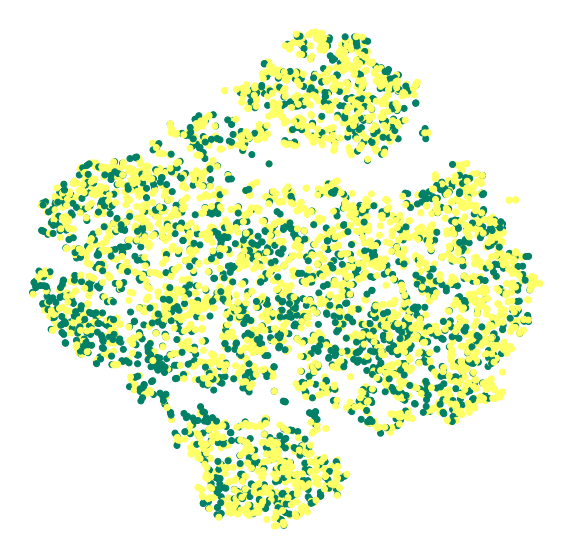

In [66]:
plt.figure(figsize=(10, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="summer")
plt.axis('off')
plt.show()

TSNE явно показывает то, что все образцы как будто лежат друг на друге и тут даже человеку трудно разделить эти два класса. Поэтому, неудивительно, что модель чуть лучше случайного классификатора.

Улучшить производительность можно путем расширения датасета (навряд ли это возможно в нашем случае) или с помощью выборки более информативных признаков.